<div style="text-align: center;">
    <div style="display: inline-block;">
        <img src="dependencies/ghr_libraries/clim4health/tutorials/figures/general/logo_bsc.png" width="275px" height="275px" />
    </div>
    <br></br>
    <h1>Training: <code>Outbreak Dengue Cariba</code></h1>

</div>
<hr style="border: 1px solid #000; width: 80%; margin: 20px auto;">

# 🧭 Table of Contents
Here’s what we’ll cover in this notebook:

- [1. Introduction](#1.-Introduction)
- [2. Setup and Data Loading](#2.-Setup-and-Data-Loading)
- [3. Data Cleaning and Preparation](#3.-Data-Cleaning-and-Preparation)
- [4. Statistics](#4.-Statistics)

---
# 1. Introduction<a name='1.-Introduction'></a>


# Dengue Outbreak Investigation in Cariba

In early March, the Ministry of Health of Cariba began receiving reports of increased dengue cases from various districts on the island. To investigate the cause and potential contributing factors, the Ministry assembled a data-driven task force to analyze population, health, and weather data. This notebook details our investigative journey and findings.

The information provided by the ministry is:
- **Population data (yearly)**: Understanding the demographic dynamics and identifying vulnerable groups.
- **Health data (monthly)**: Tracking the progression of dengue cases and related symptoms divided by gender.
- **Weather data (daily)**: Examining climate conditions from two strategic weather stations to correlate with dengue incidence with the varaibles temperature, precipitation and gust.

Our goal is to identify patterns and relationships that will inform public health interventions and disease prevention strategies.


---
# 2. Setup and Data Loading<a name='1.-Introduction'></a>

👋 **Hello and Welcome!** Before working with dengue outbreak investigation in Cariba island. we are going toset up our working environment.


## Preparation and Data Analysis Tools

The analysis relies on the following R libraries, each chosen for its capabilities in spatial data manipulation, statistical analysis, and visualization:

- **sf**: Spatial data handling and visualization.
- **zoo**: Managing time series data.
- **tidyr** and **dplyr**: Data wrangling and transformation.
- **ggplot2**: Data visualization.

This setup ensures robust and clear analysis as we tackle complex epidemiological questions.


📦 **Installing Necessary Packages**: Making sure we have all the essential tools installed for data analysis.

In [1]:
options(warn = -1)

packages <- c("sf", "zoo", "tidyr", "dplyr", "ggplot2")

installed <- packages %in% rownames(installed.packages())
if (any(!installed)) {
  install.packages(packages[!installed])
}

🔧 **Loading Libraries**: Time to load our libraries. These are the tools we'll use for exploring and visualizing our data.

In [2]:
library(sf)
library(zoo)
library(ggplot2)
library(tidyr)
library(dplyr)

Linking to GEOS 3.13.0, GDAL 3.10.1, PROJ 9.5.1; sf_use_s2() is TRUE


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union





## Loading Datasets

The datasets provided by Cariba's Ministry of Health include:

- **Monthly health reports** (`monthly_health_data_cariba.csv`): Contains records of dengue cases and symptoms reported monthly across the island, also the population of each year.
- **Daily weather observations** (`daily_weather_data_cariba.csv`): Climate variables recorded at two main weather stations on the island.
- **Weather station details** (`weather_stations_cariba.csv`): Locations and specifics of weather monitoring points.
- **Geographic Shapefile** (`cariba_shapefile`): Spatial boundary definitions and geographical divisions of Cariba.

We begin by loading these datasets into our analysis environment.


📂 **Importing Data Files**: We're importing health, weather, and geographic data provided by Cariba's Ministry of Health.

In [3]:
path_data_health  <- 'monthly_health_data_cariba.csv'
path_weather_data <- 'daily_weather_data_cariba.csv'
path_station_data <- 'weather_stations_cariba.csv'
path_shape_file   <- 'cariba_shapefile/cariba.shp'

In [4]:
df_health <- read.csv(path_data_health)
df_health$date <- as.Date(df_health$date)

df_weather<- read.csv(path_weather_data)
df_station<- read.csv(path_station_data)

shape_file <- st_read(path_shape_file)

Reading layer `cariba' from data source 
  `C:\Users\rcapella\Documents\GitHub\training_CARPHA\cariba_shapefile\cariba.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 14 features and 13 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -20.31369 ymin: 17.11005 xmax: -19.36612 ymax: 17.95281
Geodetic CRS:  WGS 84



### Health Data Overview

This dataset includes reported dengue cases and related health data per month. Inspecting the first few rows gives us a sense of the data structure, including dates and reported figures.


👩‍⚕️ **Previewing Health Data**: Let's check out the health data first to see what we're working with.

In [5]:
print(head(df_health))

        date year month    district cases population male_cases female_cases
1 2014-01-01 2014     1   Ravenwick     7     270047          3            4
2 2014-01-01 2014     1   Stonevale     1      30129          0            1
3 2014-01-01 2014     1     Ashford     0       6254          0            0
4 2014-01-01 2014     1   Mourndell     0       7923          0            0
5 2014-01-01 2014     1  Brightmere     0       2526          0            0
6 2014-01-01 2014     1 Falconridge     0      56559          0            0



### Weather Data Overview

Daily weather observations such as temperature, humidity, and precipitation are crucial as dengue outbreaks often correlate with specific climate conditions. Here's a preview of this detailed daily weather dataset.


🌦️ **Checking Weather Data**: Now, let's take a quick peek at the daily weather observations.

In [6]:
print(head(df_weather))

            date_time w1_precipitation w2_precipitation w1_temperature
1 2014-01-01 12:00:00     4.821194e-05     4.645360e-05       25.73740
2 2014-01-02 12:00:00     4.916164e-05     1.117858e-05       25.77120
3 2014-01-03 12:00:00     0.000000e+00     0.000000e+00       25.67523
4 2014-01-04 12:00:00     4.783273e-06     7.949769e-06       26.06198
5 2014-01-05 12:00:00     1.725107e-04     1.794845e-05       25.32960
6 2014-01-06 12:00:00     7.505644e-05     1.821224e-05       25.88913
  w2_temperature  w1_gust  w2_gust
1       25.07160 13.21383 13.12820
2       26.08188 13.12873 13.17093
3       25.98242 11.46100 11.85394
4       26.15018 12.29832 12.70860
5       25.87054 13.77384 13.91867
6       25.23828 12.70048 12.55845



### Weather Station Information

The precise locations and operational details of weather stations are key for spatial correlation analysis. These stations provide daily climatic conditions from geographically strategic points.


📍 **Weather Station Details**: Let's confirm details of the weather stations which gather daily data.

In [7]:
print(head(df_station))

  weather_station latitude longitude
1       Ravenwick    17.71    -19.93
2        Oakshire    17.27    -19.55



### Geographical Boundaries of Cariba

Visualizing Cariba’s geographical divisions helps us spatially map dengue case distributions and relate them with environmental variables.


🗺️ **Exploring Geographic Boundaries**: Here's a first look at the shapefile data showing geographic boundaries of Cariba.

In [8]:
print(head(shape_file))

Simple feature collection with 6 features and 13 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -20.21889 ymin: 17.17549 xmax: -19.53775 ymax: 17.95281
Geodetic CRS:  WGS 84
  DPA_CANTON  DPA_DESCAN DPA_PROVIN  DPA_DESPRO       X       Y X_2014 X_2015
1       0701   Ravenwick         07 The Captain 40.0545 38.6896   1224   4054
2       0702   Stonevale         07 The Captain 39.9132 38.3977    155    394
3       0703     Ashford         07 The Captain 40.2819 38.4465     NA     NA
4       0704   Mourndell         07 The Captain 40.1624 38.2310      0      0
5       0705  Brightmere         07 The Captain 40.3726 38.5582      0      0
6       0706 Falconridge         07 The Captain 40.2176 38.8330    318    917
  X_2016 X_2017 X_2018 X_2019 X_2020                       geometry
1   4710   5078   5230   5477   6086 POLYGON ((-19.92876 17.8289...
2    455    549    565    565    566 POLYGON ((-20.03906 17.6042...
3     NA     NA     NA     NA     NA POLYGON ((-19.760


## Initial Geographical Visualization

To begin, we visualize Cariba's districts clearly defined by the geographical shapefile. This map will later overlay with dengue cases and weather station locations to spatially assess correlations and outbreak patterns.


🌎 **Visualizing Cariba's Map**: Let's visualize Cariba island and understand its districts better to map the outbreak accurately.

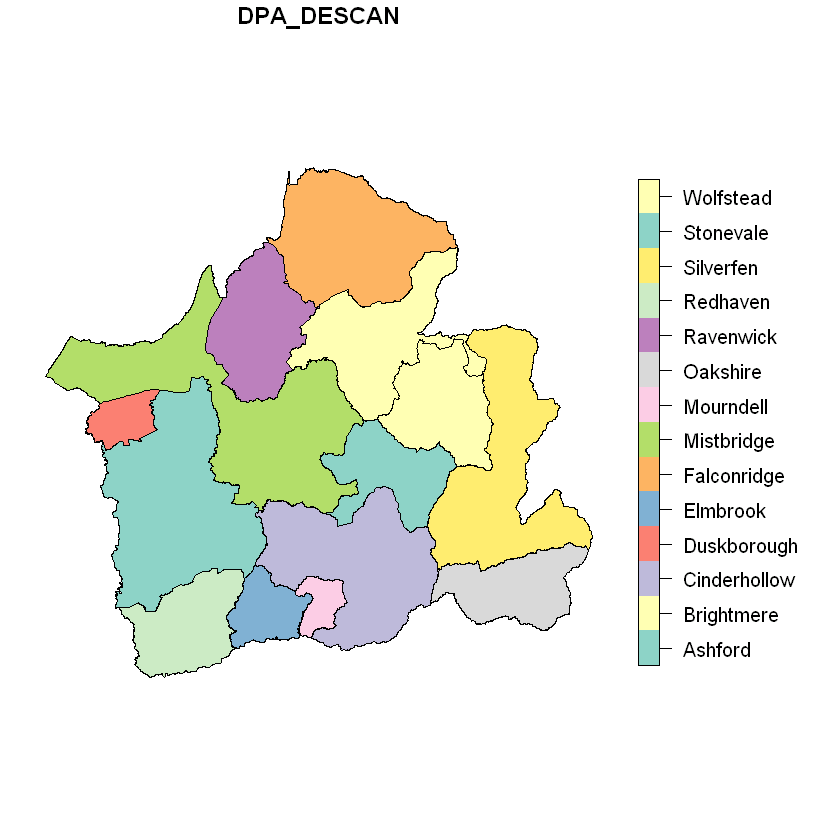

In [9]:
plot(shape_file['DPA_DESCAN'])

🌎 **Visualizing Cariba's Map**: Once that we know the different districts of the islad we want to identify where are the different weather stations in the island

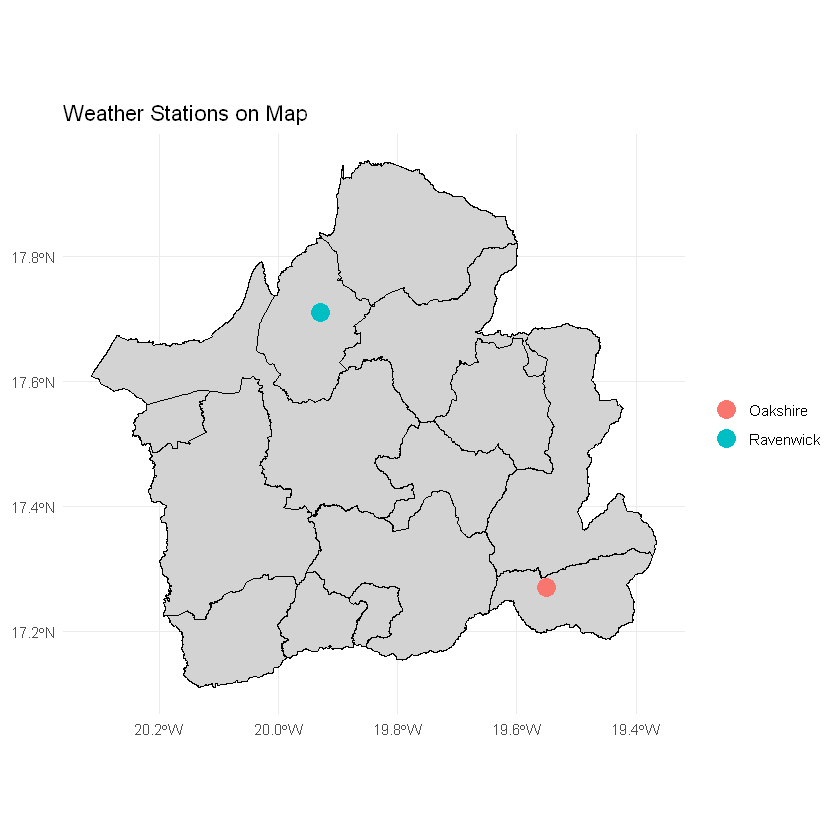

In [10]:
weather_sf <- st_as_sf(df_station, coords = c("longitude", "latitude"), crs = 4326)

# Plot shapefile + weather stations
ggplot() +
  geom_sf(data = shape_file, fill = "lightgray", color = "black") +
  geom_sf(data = weather_sf, aes(color = weather_station), size = 5) +
  theme_minimal() +
  labs(title = "Weather Stations on Map") +
  theme(legend.title = element_blank())

---
# 3. Data Cleaning and Preparation

🔍 **Let’s Check for Missing Data!**  
Before diving deeper into the analysis, it's essential to check if there are any missing (null) values in our datasets. Missing data can affect our results, so let’s identify and handle them early on!

In [11]:
colSums(is.na(df_weather))

date_time w1_precipitation w2_precipitation   w1_temperature 
               0                0                0              164 
  w2_temperature          w1_gust          w2_gust 
               0                0                0

🌡️ **We Found Some Missing Temperature Data**  
While exploring the weather data, we noticed that the temperature column for the **first weather station** contains some missing values. To fix this and maintain accuracy, we’ll replace each missing value with the **average of the previous and next valid temperature readings**. This approach helps preserve the natural variation in the data without introducing bias.

In [12]:
df_weather$w1_temperature <- na.approx(df_weather$w1_temperature)

colSums(is.na(df_weather))

date_time w1_precipitation w2_precipitation   w1_temperature 
               0                0                0                0 
  w2_temperature          w1_gust          w2_gust 
               0                0                0

📆 **Time to Align Our Data!**  
Our health data is reported on a **monthly** basis, but our weather data is recorded **daily**.  
To make meaningful comparisons and correlations, we’ll aggregate the **daily weather data into monthly averages**. This ensures both datasets are on the same time scale, allowing us to explore how weather trends relate to dengue cases.


In [13]:
df_weather$date_time <- as.Date(df_weather$date_time)
df_weather$month <- format(df_weather$date_time, "%Y-%m")

monthly_avg <- aggregate(
    cbind(w1_precipitation, w2_precipitation, w1_temperature, w2_temperature, w1_gust, w2_gust) ~ month,
    data = df_weather,
    FUN = function(x) mean(x, na.rm = TRUE)
)

print(head(monthly_avg))

    month w1_precipitation w2_precipitation w1_temperature w2_temperature
1 2014-01     6.161188e-05     3.559217e-05       25.20907       25.48898
2 2014-02     4.598094e-05     3.490798e-05       25.01914       25.27336
3 2014-03     6.449551e-05     5.519112e-05       24.94154       25.06989
4 2014-04     4.399253e-05     3.449424e-05       25.81095       25.82051
5 2014-05     5.642852e-05     2.028299e-05       26.37593       26.40404
6 2014-06     1.639586e-04     9.115205e-05       26.73950       26.72659
   w1_gust  w2_gust
1 12.49530 12.86711
2 11.39230 11.83765
3 10.47539 10.70382
4 11.19145 11.23368
5 10.79040 10.86221
6 11.77623 11.93130


🗺️ **Filling the Gaps Across the Island!**  
Our weather data comes from only **two weather stations**, but we need weather information for **all districts** of Cariba to understand the environmental conditions influencing the dengue outbreak.

To solve this, we’ll use **spatial interpolation** to estimate weather variables and other climate values across the entire island based on the existing stations.

⚠️ **Note:** Since we only have data from two stations, these interpolated values are an approximation. The accuracy of this step would **greatly improve if we had more stations** distributed across the island. Still, this approach gives us a valuable starting point for island-wide analysis.


In [14]:
# Calculate centroid and coordinates
coords <- st_coordinates(st_centroid(shape_file))

# Function IDW
idw <- function(x, y, stations, values, p = 2) {
  d <- sqrt((stations$longitude - x)^2 + (stations$latitude - y)^2)
  d[d == 0] <- 1e-12
  w <- 1 / d^p
  sum(w * values) / sum(w)
}

# Vars
vars <- c("temperature", "precipitation", "gust")
prefixes <- c("w1_", "w2_")

# Iterate over months and variables
for (m in unique(monthly_avg$month)) {
  row_data <- monthly_avg[monthly_avg$month == m, ]
  if (nrow(row_data) == 0) next

  for (v in vars) {
    cols <- paste0(prefixes, v)
    if (!all(cols %in% names(row_data))) next  # Saltar si faltan columnas

    vals <- unlist(row_data[cols])
    interp <- apply(coords, 1, \(c) idw(c[1], c[2], df_station, vals))
    col_name <- paste0(v, "_", gsub("-", "_", m))
    shape_file[[col_name]] <- interp
  }
}

🌡️🗺️ **Visualizing Interpolated Temperature Across Cariba**  
Now that we've interpolated temperature values for all districts, it's time to **visualize the results on a map**!    
This map will show how temperature varies across the island, based on the estimates from our two weather stations. Even with limited data, this visualization helps us identify **potential hotspots** where climate conditions may be more favorable for dengue transmission.

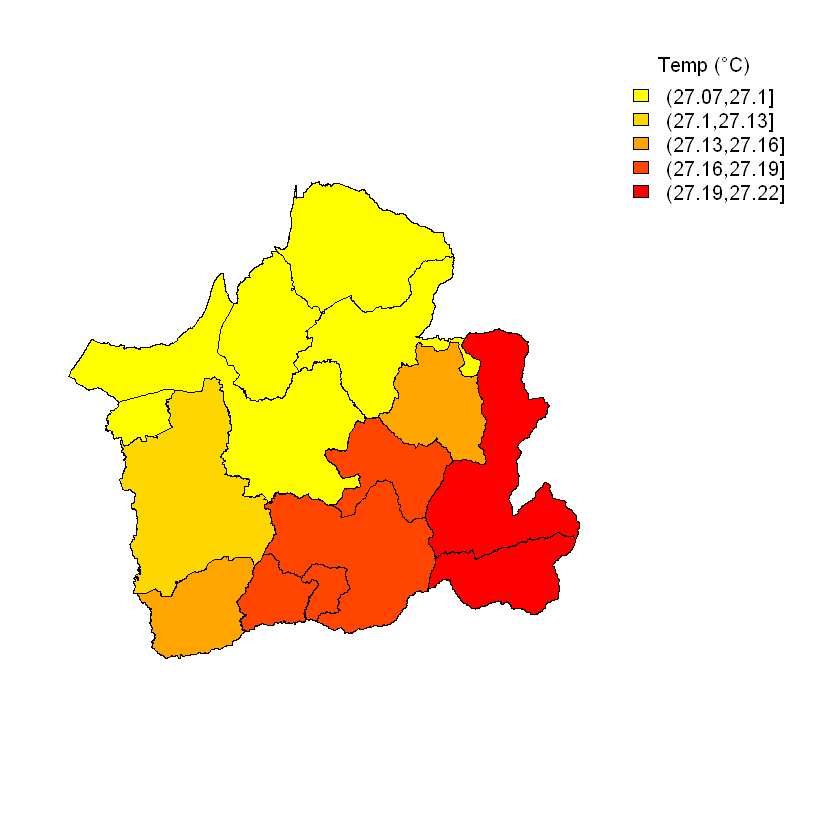

In [15]:
par(mar = c(2, 2, 2, 10))

# Colors and cuts
colors <- c("yellow", "gold", "orange", "orangered", "red")
cuts <- cut(shape_file$temperature_2020_07, breaks = 5, labels = FALSE)

# Plot
plot(shape_file["geometry"], col = colors[cuts], border = 1)
legend("topright", inset = c(-0.35, 0), fill = colors,
       legend = levels(cut(shape_file$temperature_2020_07, breaks = 5)),
       title = "Temp (°C)", xpd = TRUE, bty = "n")


🔗 **Bringing It All Together – District by District!**  
Now that we have processed both the **health data** (monthly dengue reports) and the **weather data** (interpolated and aggregated by district), it’s time to **merge everything**.  

This unified dataset will give us a comprehensive view of each district’s health situation along with the local climate conditions. With this, we’ll be able to **analyze correlations** and uncover important patterns related to the dengue outbreak in Cariba. 🦟🌧️📊

In [16]:
df_weather <- shape_file %>%
  st_drop_geometry() %>%
  select(DPA_DESCAN, matches("^(temperature|precipitation|gust)_")) %>%
  pivot_longer(
    cols = -DPA_DESCAN,
    names_to = c("var", "date"),
    names_pattern = "^(.*)_(\\d{4}_\\d{2})$",
    values_to = "value"
  ) %>%
  pivot_wider(
    names_from = var,
    values_from = value
  ) %>%
  mutate(date = as.Date(paste0(gsub("_", "-", date), "-01")))

names(df_weather) <- c('district', 'date', 'temperature', 'precipitation', 'gust')

df_weather <- as.data.frame(df_weather)

df <- merge(df_health, df_weather, c('district', 'date'))

print(head(df))

  district       date year month cases population male_cases female_cases
1  Ashford 2014-01-01 2014     1     0       6254          0            0
2  Ashford 2014-02-01 2014     2     0       6254          0            0
3  Ashford 2014-03-01 2014     3     0       6254          0            0
4  Ashford 2014-04-01 2014     4     0       6254          0            0
5  Ashford 2014-05-01 2014     5     0       6254          0            0
6  Ashford 2014-06-01 2014     6     0       6254          0            0
  temperature precipitation     gust
1    25.39329  4.448730e-05 12.74000
2    25.18645  3.869340e-05 11.68540
3    25.02601  5.837193e-05 10.62573
4    25.81724  3.774133e-05 11.21925
5    26.39443  3.263974e-05 10.83766
6    26.73101  1.160418e-04 11.87828


🆕📨 **New Data Alert from the Ministry!**  
We've just received an **updated report** from the Ministry of Health for the district of **Ravenwick** in **March 2020**. This data is more accurate and should replace or be carefully merged with what we had before.

Let’s go ahead and **filter this specific data** so we can either update our existing records or analyze it separately. Keeping the dataset accurate and up-to-date is key to reliable conclusions! 🗂️🔍

In [17]:
print(df %>% filter(district == "Ravenwick", format(date, "%Y-%m") == "2020-03"))

   district       date year month cases population male_cases female_cases
1 Ravenwick 2020-03-01 2020     3   114     289141         68           46
  temperature precipitation     gust
1    25.45982  5.981915e-05 10.02347


✏️🛠️ **Correcting Inaccurate Case Numbers for Ravenwick – March 2020**  
Upon reviewing the updated report from the Ministry, we discovered an error in the number of dengue cases reported for **Ravenwick** in **March 2020**.

- The **previous data** indicated:
  - 👨 Male cases: **70**
  - 👩 Female cases: **44**

However, this has been confirmed as **incorrect**. We will now **filter and update** this specific record to ensure our analysis reflects the corrected figures. Data accuracy is crucial for making the right decisions in public health! 📊✅


In [18]:
df <- df %>%
  mutate(
    male   = ifelse(district == "Ravenwick" & format(date, "%Y-%m") == "2020-03", 70, male_cases  ),
    female = ifelse(district == "Ravenwick" & format(date, "%Y-%m") == "2020-03", 44, female_cases)
  )


print(df %>% filter(district == "Ravenwick", format(date, "%Y-%m") == "2020-03"))

   district       date year month cases population male_cases female_cases
1 Ravenwick 2020-03-01 2020     3   114     289141         68           46
  temperature precipitation     gust male female
1    25.45982  5.981915e-05 10.02347   70     44


### ****** Exercise 1: ****** 
Filter the data with this information:
- District: Wolfstead
- Date    : 2017-10

---
## 4. Statistics

📈🕒 **Island-Wide Dengue Trends Over Time**  
Let’s take a step back and look at the **big picture** – how have dengue cases behaved across **all of Cariba** over time?

We’ll create a **time series** to visualize monthly dengue cases island-wide. This will help us detect **seasonality** in the disease – patterns that repeat over time – and identify any **unusual peaks**, like the major **outbreak in 2015**.  

By understanding these temporal patterns, we can better prepare for future surges and align health resources more effectively. 🦟📆


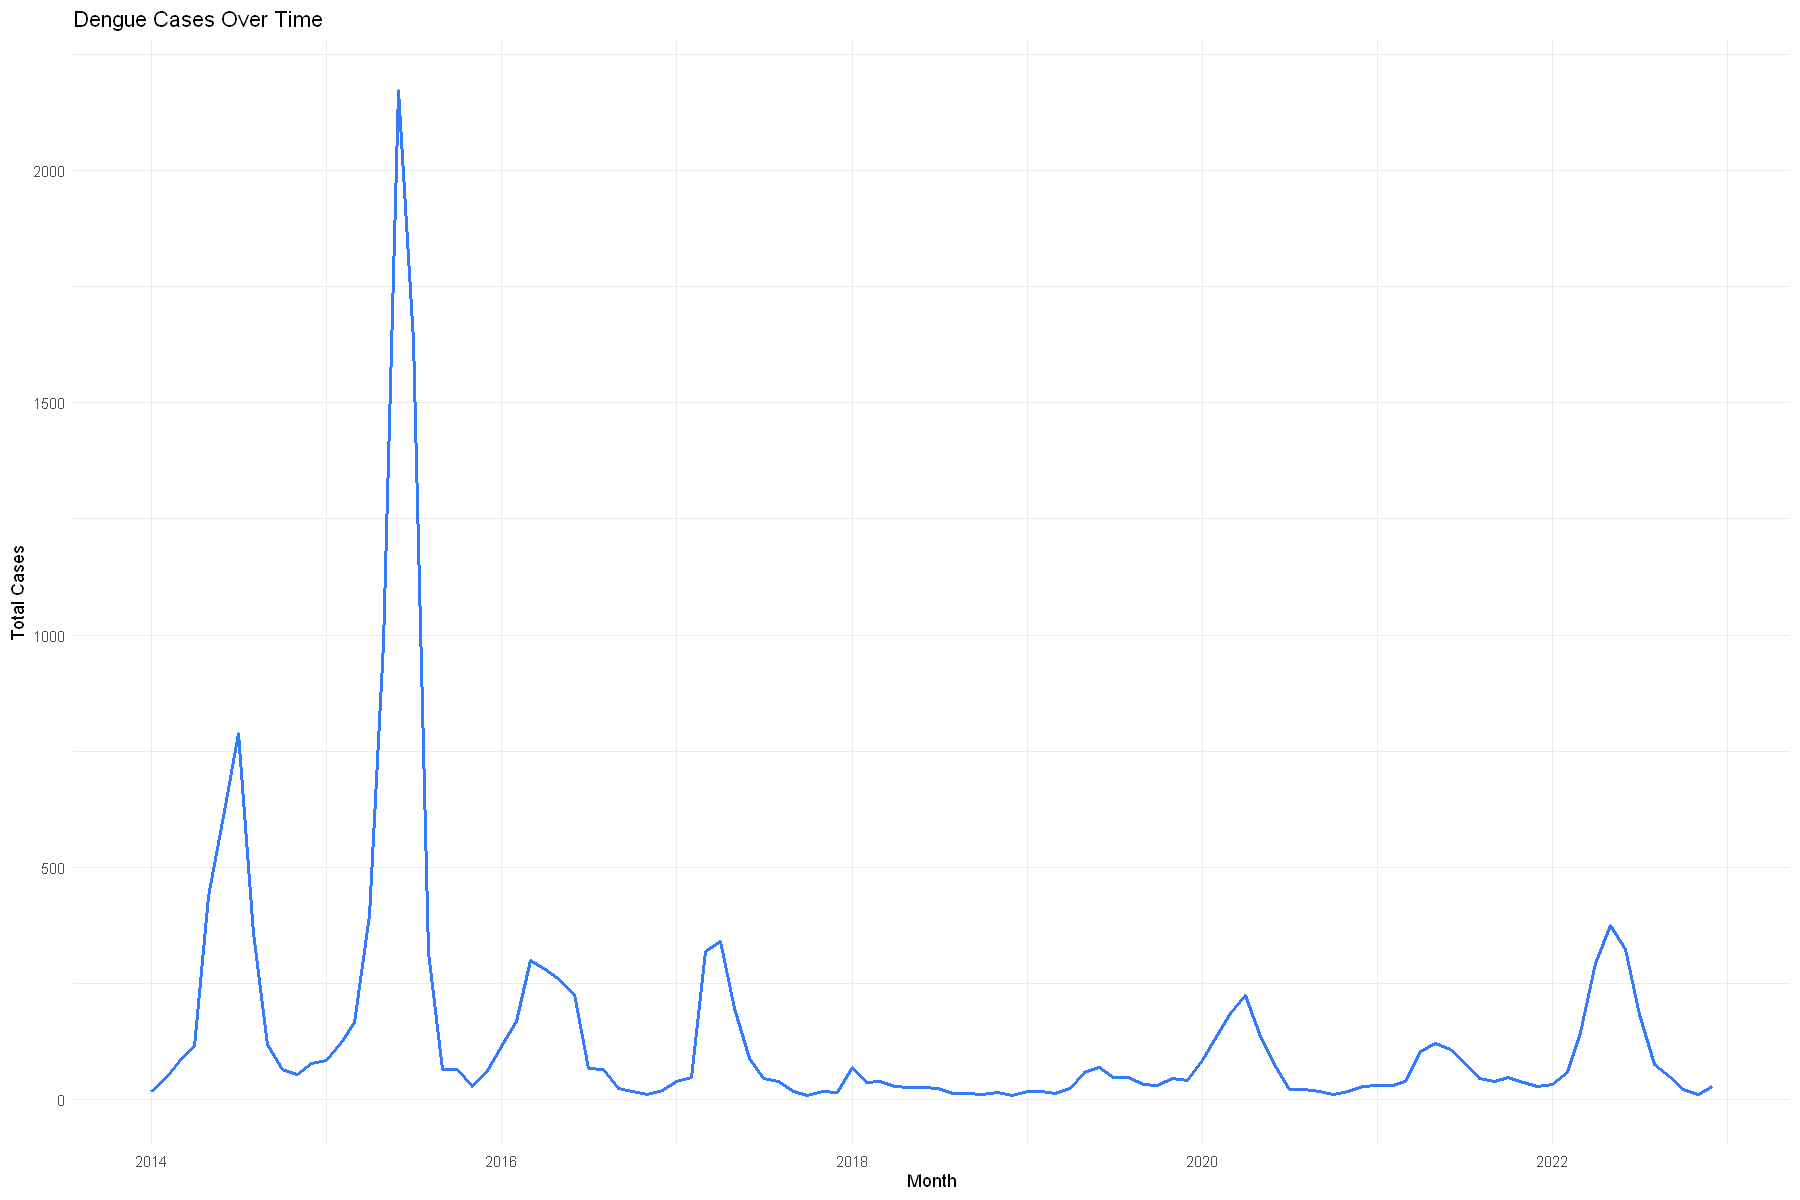

In [19]:
options(repr.plot.width = 15, repr.plot.height =10) 

df %>%
  group_by(date) %>%  # assuming date is like "2020-03-01"
  summarise(cases = sum(cases, na.rm = TRUE)) %>%
  ggplot(aes(x = as.Date(date), y = cases)) +
  geom_line(color = "#337aff", size = 1) +
  labs(title = "Dengue Cases Over Time",
       x = "Month",
       y = "Total Cases") +
  theme_minimal()

👩‍⚕️👨‍⚕️ **Dengue Time Series by Gender**  
To better understand how the disease affects different groups, we’ll now split our time series into **male** and **female** dengue cases.

This breakdown allows us to explore whether **seasonality** or **peak periods** impact one gender more than the other, and whether public health responses should be **gender-sensitive**.

Let’s visualize these trends and compare how dengue evolves over time for both men and women across the island. 📊📅


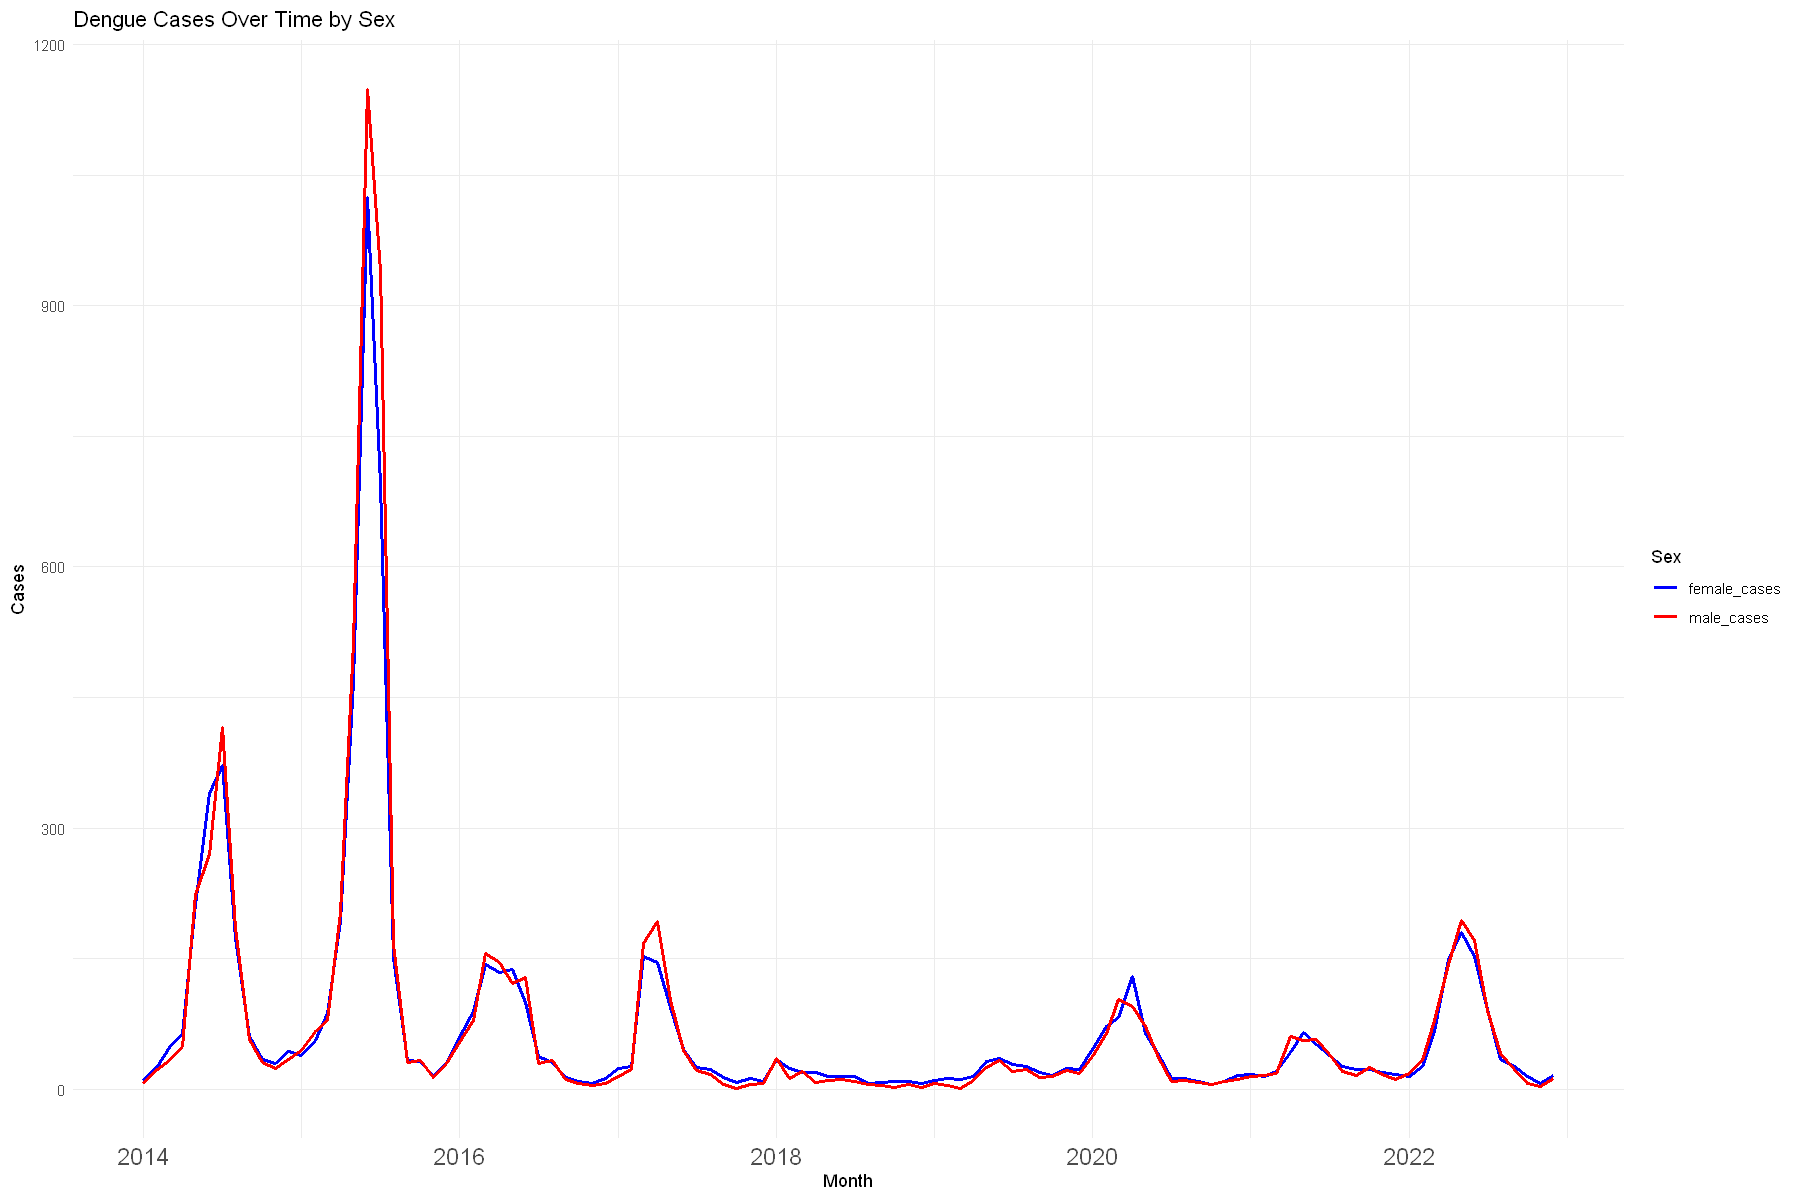

In [20]:
options(repr.plot.width = 15, repr.plot.height = 10)

df %>%
  group_by(date) %>%
  summarise(
    male_cases = sum(male_cases, na.rm = TRUE),
    female_cases = sum(female_cases, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  pivot_longer(cols = c(male_cases, female_cases), names_to = "sex", values_to = "cases") %>%
  ggplot(aes(x = as.Date(date), y = cases, color = sex)) +
  geom_line(size = 1) +
  scale_color_manual(values = c("male_cases" = "red", "female_cases" = "blue")) +
  labs(title = "Dengue Cases Over Time by Sex",
       x = "Month",
       y = "Cases",
       color = "Sex") +
  theme_minimal() +
  theme(axis.text.x = element_text(size = 14))

### ****** Exercise 2: ****** 
Copy the previous code and change the colors of the previous graph:
- male_cases: yellow
- female_cases: blue

🔥🦟 **Heatmap: Linking Temperature and Dengue Across Cariba**  
Now we’re going to create a **heatmap** that shows dengue cases across **all districts**, **months**, and **years**, combined with **temperature levels**.

This will help us explore a key scientific question:  
👉 *What is the optimal temperature range for dengue transmission on the island of Cariba?*

By visualizing the relationship between **temperature** and **disease incidence**, we can better understand the environmental conditions that make outbreaks more likely — and potentially **predict future surges**. 🌡️📆🌍

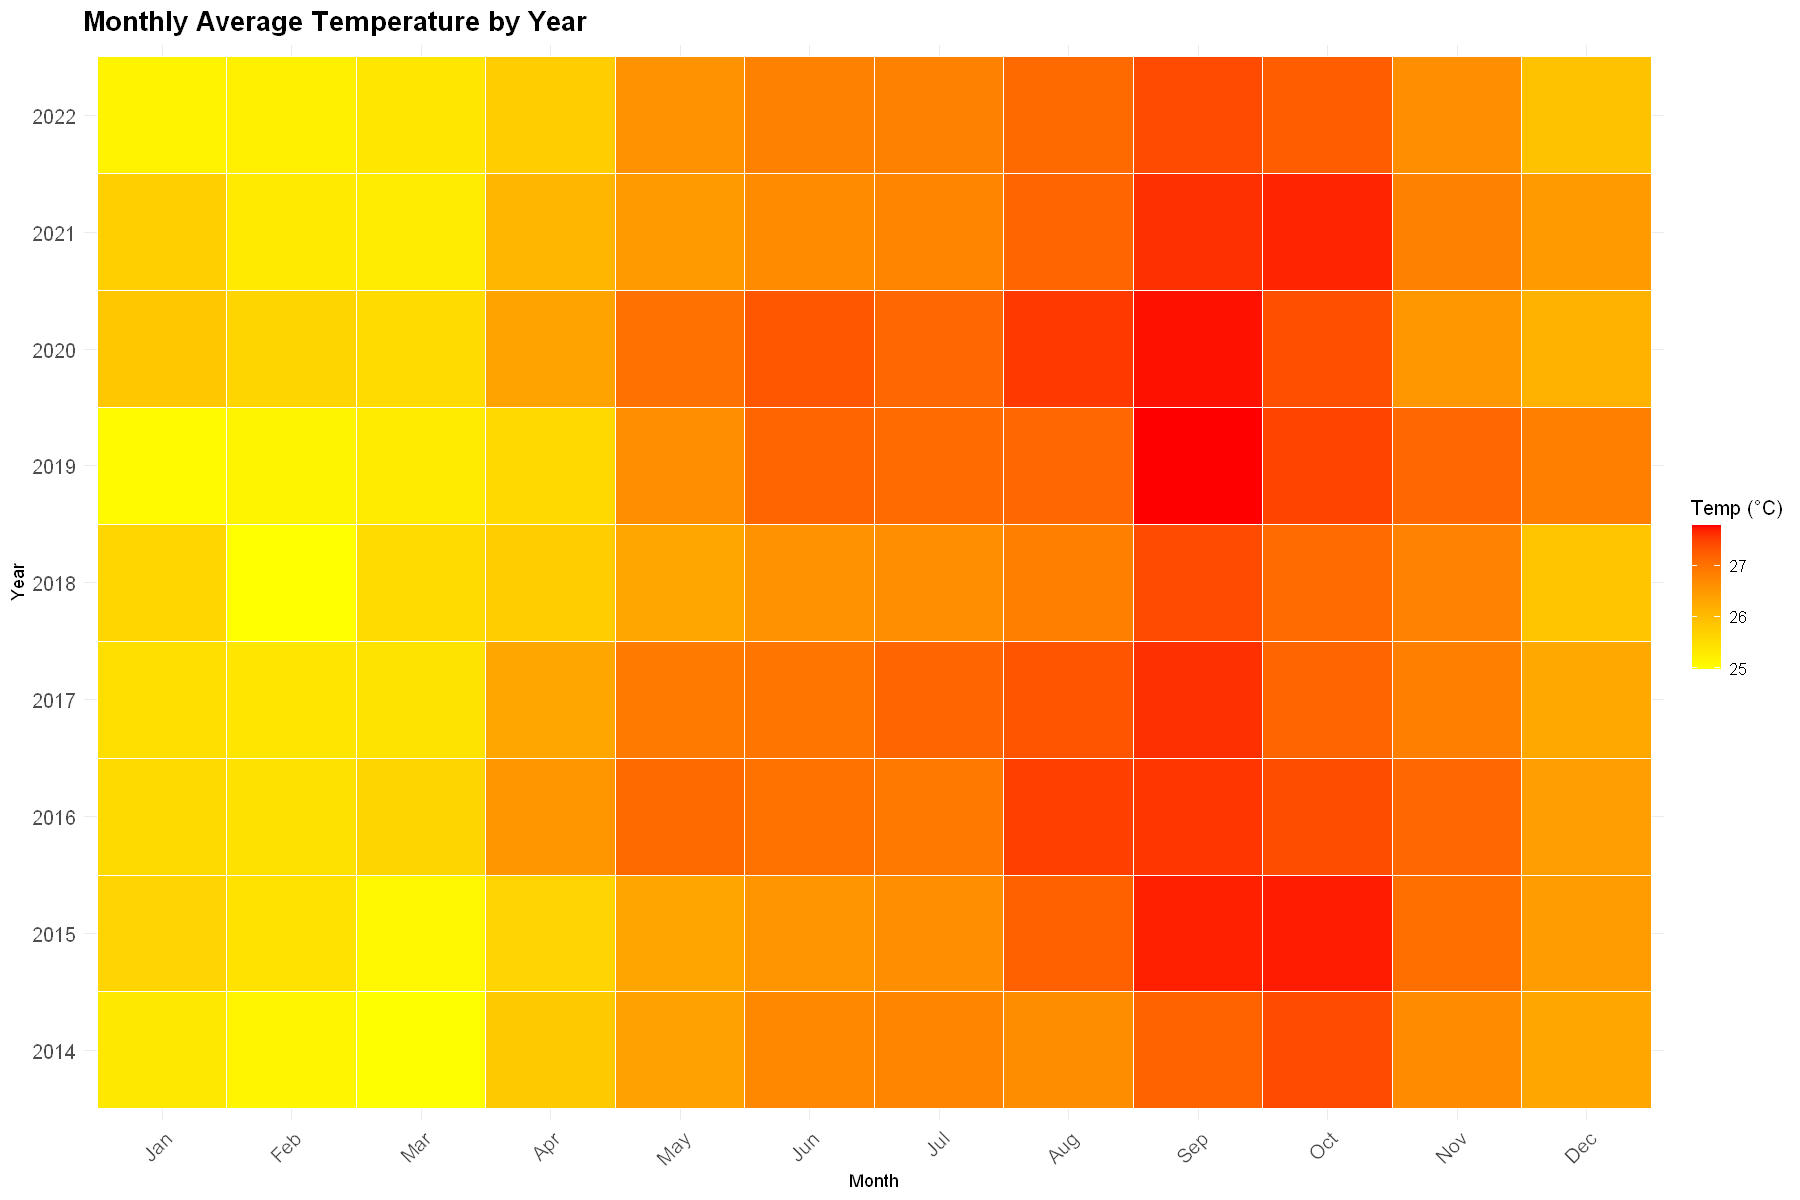

In [21]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Create months and years
df$month <- format(df$date, "%b")  # Mes abreviado
df$month <- factor(df$month, levels = month.abb)  # Orden correcto de meses
df$year <- format(df$date, "%Y")  # Año como texto

# Calcular la media de temperatura por año y mes
df_plot <- aggregate(temperature ~ year + month, data = df, FUN = mean, na.rm = TRUE)

# Create heatmap
ggplot(df_plot, aes(x = month, y = factor(year), fill = temperature)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "yellow", high = "red", name = "Temp (°C)") +
  labs(
    title = "Monthly Average Temperature by Year",
    x = "Month",
    y = "Year"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 12),
    plot.title = element_text(size = 16, face = "bold"),
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10)
  )


🗓️🌡️ **Heatmap: Monthly Dengue Intensity Over the Years**  
Now we’ll create a **monthly heatmap** to see how dengue cases have evolved throughout the **calendar months across all available years**.

Each cell in the heatmap will show the **total number of cases** for a given month and year, making it easy to identify patterns like:
- 🚨 **Outbreak months**
- 🔁 **Seasonal repetition**
- 🔥 **Unusual spikes in specific years**

We’ll use a custom color scale to reflect intensity:
- 🟩 **0–29 cases**
- 🟨 **30–69 cases**
- 🟧 **70–100 cases**
- 🟥 **100+ cases**

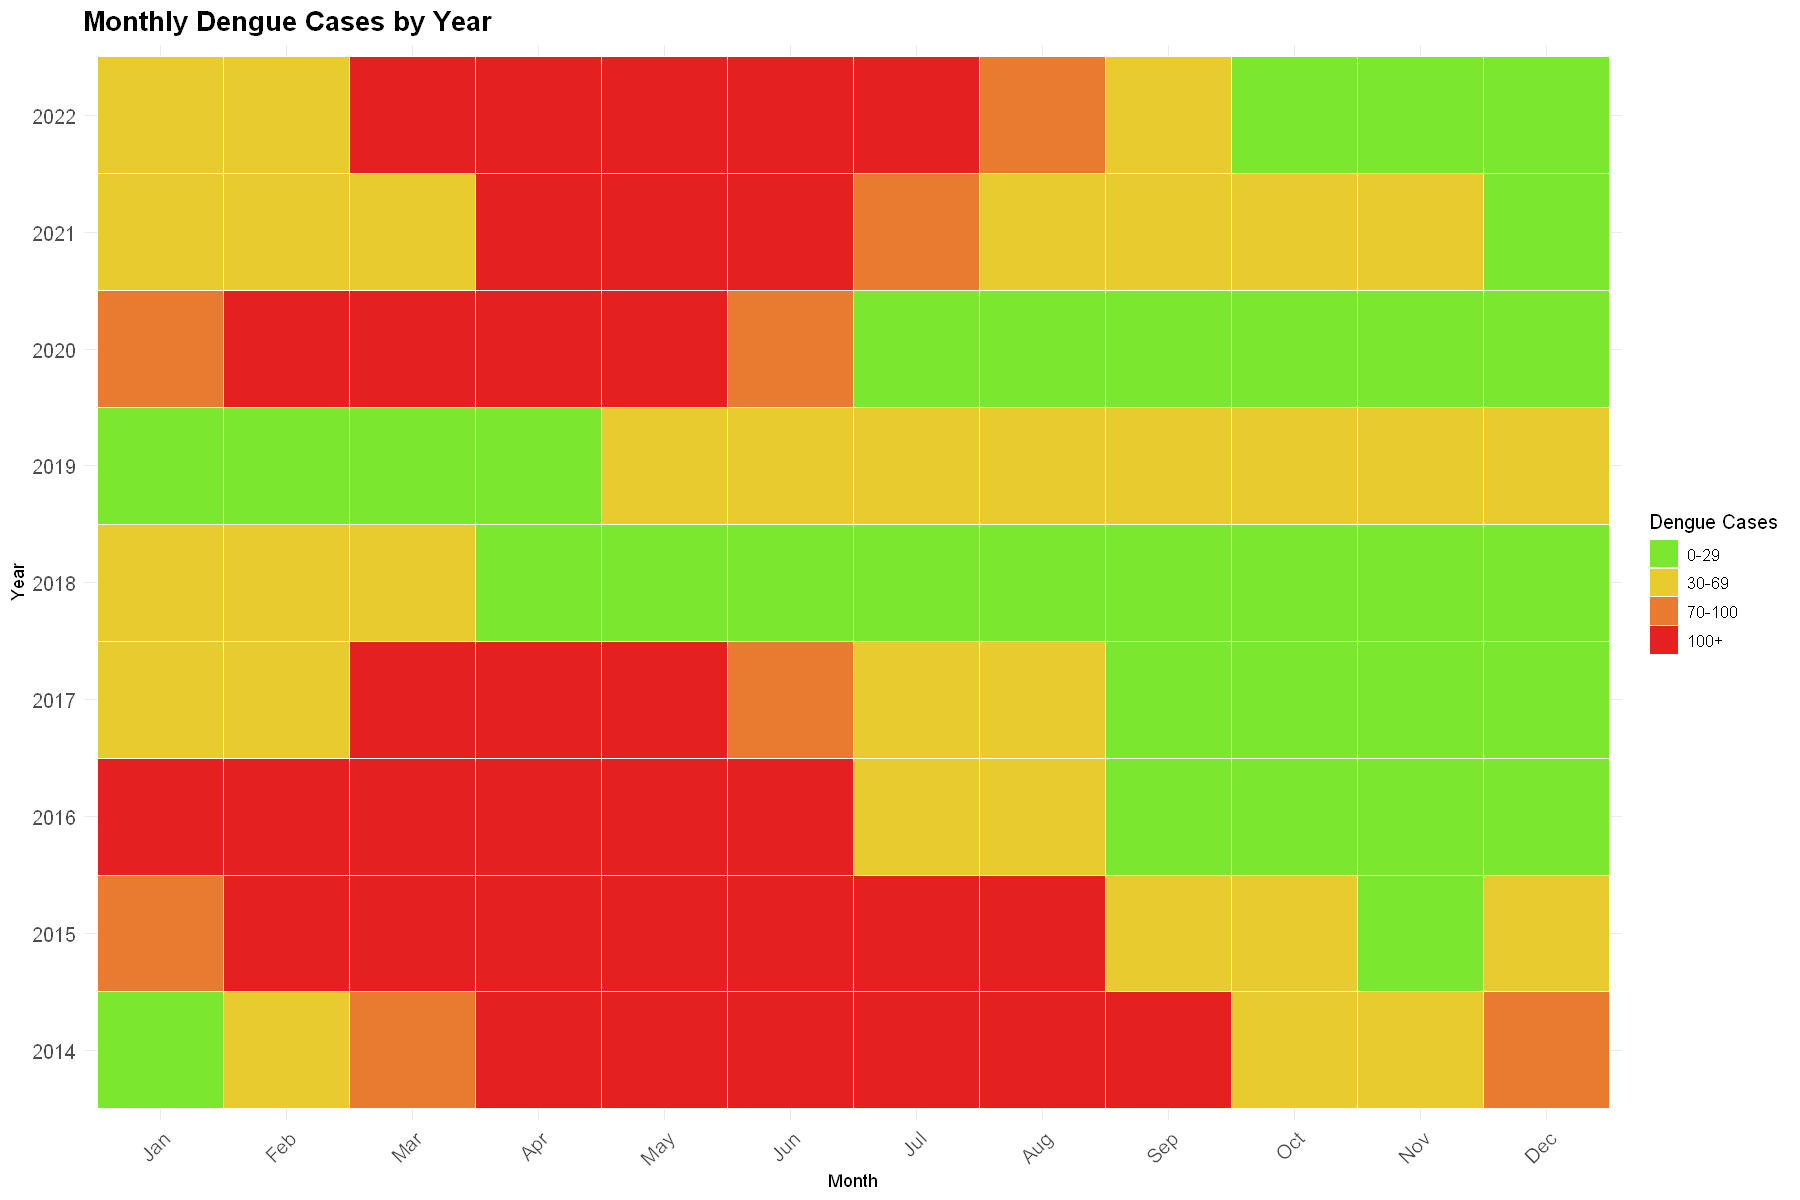

In [22]:
# Create columns months and year
df$month <- format(df$date, "%b")
df$month <- factor(df$month, levels = month.abb)  # Asegurar orden correcto
df$year <- format(df$date, "%Y")

# Calculate total cases by month year and year
df_plot <- aggregate(cases ~ year + month, data = df, sum, na.rm = TRUE)

# Clasificate in range of cases
df_plot$case_range <- with(df_plot, ifelse(cases <= 29, "0-29",
                                    ifelse(cases <= 69, "30-69",
                                    ifelse(cases <= 100, "70-100", "100+"))))

# Convert in the range of cases
df_plot$case_range <- factor(df_plot$case_range, levels = c("0-29", "30-69", "70-100", "100+"))

# Create the heatmap
ggplot(df_plot, aes(x = month, y = factor(year), fill = case_range)) +
  geom_tile(color = "white") +
  scale_fill_manual(
    values = c(
      "0-29"   = "#7be82f",
      "30-69"  = "#e8cc2f",
      "70-100" = "#e87b2f",
      "100+"   = "#e52020"
    ),
    name = "Dengue Cases"
  ) +
  labs(
    title = "Monthly Dengue Cases by Year",
    x = "Month",
    y = "Year"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 12),
    plot.title = element_text(size = 16, face = "bold"),
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10)
  )


### ****** Exercise 3: ****** 
Copy the previous code and change the range of the cases to:
- 0-40
- 41-80
- 81-120
- +120

📊🏝️ **Dengue Cases by District – Where Did It Hit Hardest?**  
Let’s now take a closer look at how dengue affected each **district** in Cariba using **bar plots**.

By visualizing the **total number of cases per district**, we can clearly identify the most affected areas.

🔴 Unsurprisingly, **Ravenwick**, the **capital of Cariba**, stands out with the **highest number of dengue cases by far** – a major hotspot in the outbreak.

Following Ravenwick, the districts of:
- 🟠 **Wolfstead**
- 🟠 **Falconridge**
- 🟠 **Mistbridge**

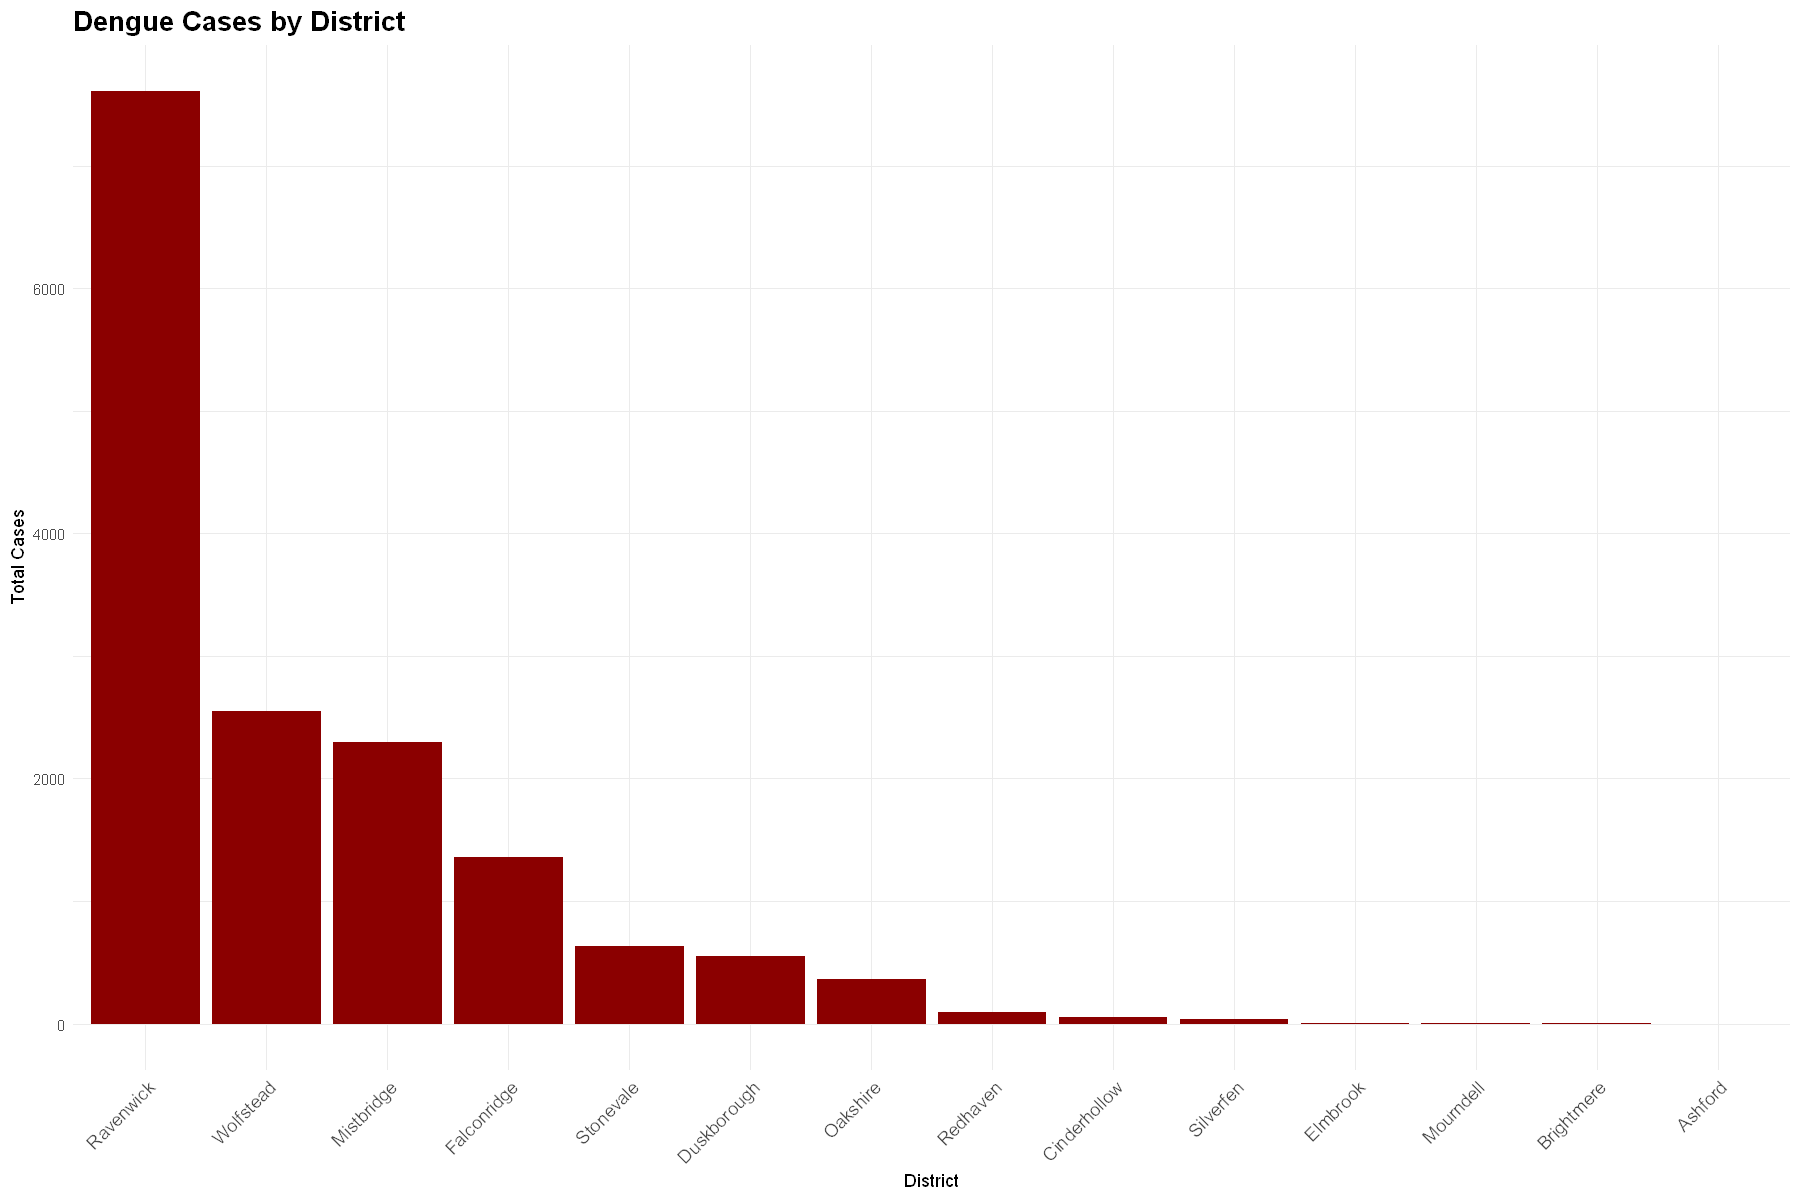

In [23]:
# Agregate and sum cases
df_plot <- aggregate(cases ~ district, data = df, sum, na.rm = TRUE)

# Order districts by number of cases
df_plot$district <- factor(df_plot$district, levels = df_plot$district[order(-df_plot$cases)])

# Create the graph
ggplot(df_plot, aes(x = district, y = cases)) +
  geom_bar(stat = "identity", fill = "darkred") +
  labs(
    title = "Dengue Cases by District",
    x = "District",
    y = "Total Cases"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 11),
    plot.title = element_text(size = 16, face = "bold")
  )


📊📈 **Ravenwick’s Monthly Dengue Pattern – A Bell-Shaped Trend**  
Zooming in on **Ravenwick**, the capital of Cariba, we create a **monthly barplot** to observe how dengue cases are distributed throughout the year.

Interestingly, the data reveals a **Gaussian-like (bell-shaped) curve**, with a clear **peak in June**.  

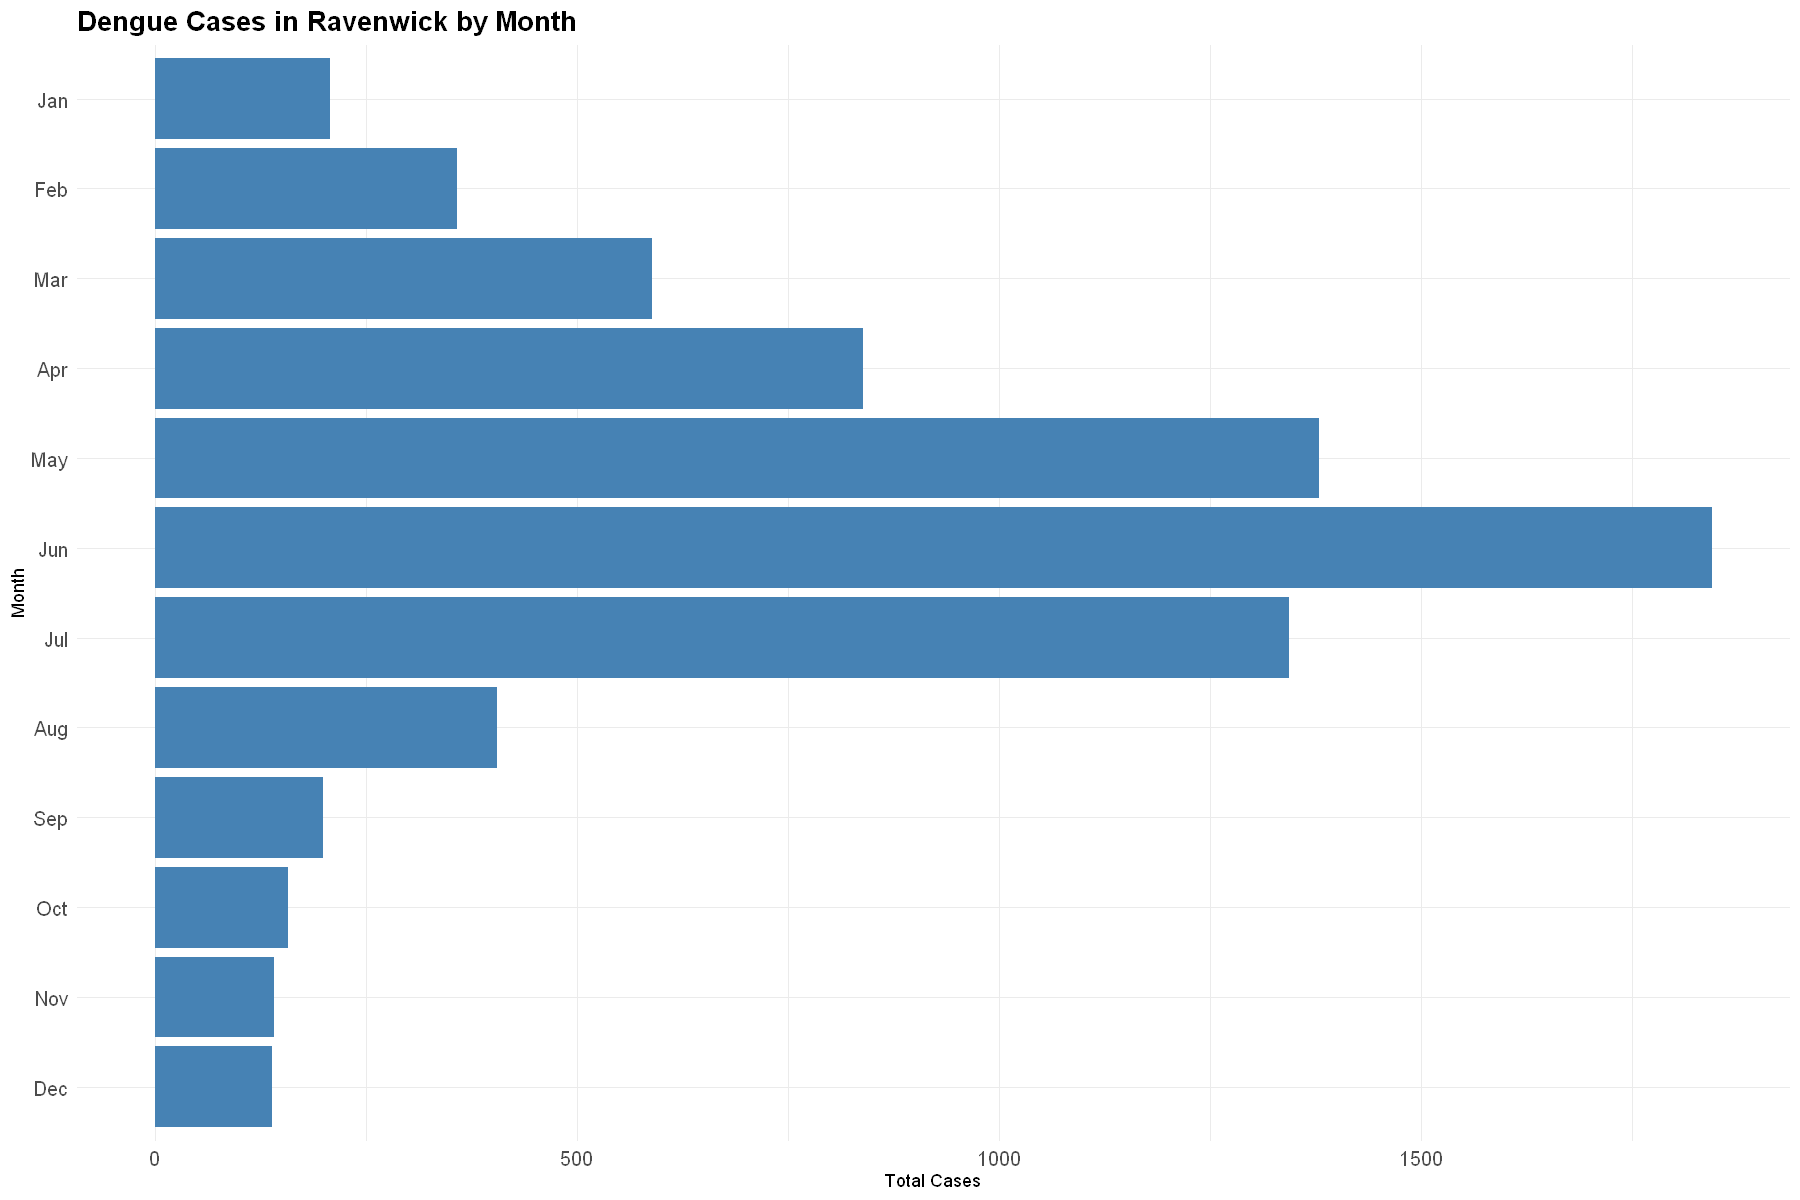

In [24]:
# Filter and preparate data in base R + ggplot
df_ravenwick <- df[df$district == "Ravenwick", ]
df_ravenwick$month <- format(df_ravenwick$date, "%b")  # Abreviado (Jan, Feb, etc.)
df_ravenwick$month <- factor(df_ravenwick$month, levels = rev(month.abb))  # Orden correcto descendente

# Sum cases by month
df_plot <- aggregate(cases ~ month, data = df_ravenwick, sum, na.rm = TRUE)

# Do the horizontal graph
ggplot(df_plot, aes(x = cases, y = month)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  labs(
    title = "Dengue Cases in Ravenwick by Month",
    x = "Total Cases",
    y = "Month"
  ) +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 12),
    plot.title = element_text(size = 16, face = "bold")
  )


🗺️🔴 **Mapping the Outbreak – Hotspots Across Cariba**  
To conclude our analysis, we’ll visualize the **total number of dengue cases per district on a map** of Cariba.

This map gives us a clear picture of how the outbreak is **spatially distributed** across the island:

- 🏙️ **Ravenwick**, the capital, located centrally, stands out as the **most affected district** by far.
- 🌍 Surrounding districts like **Wolfstead**, **Falconridge**, and **Mistbridge** also show **elevated case counts**, forming a visible **cluster of high-risk zones** in and around the heart of the island.

This spatial concentration suggests that urban density, mobility, or shared environmental factors could be driving the outbreak pattern.  
Such insights are vital for planning **localized response strategies**. 🎯🦟🚑


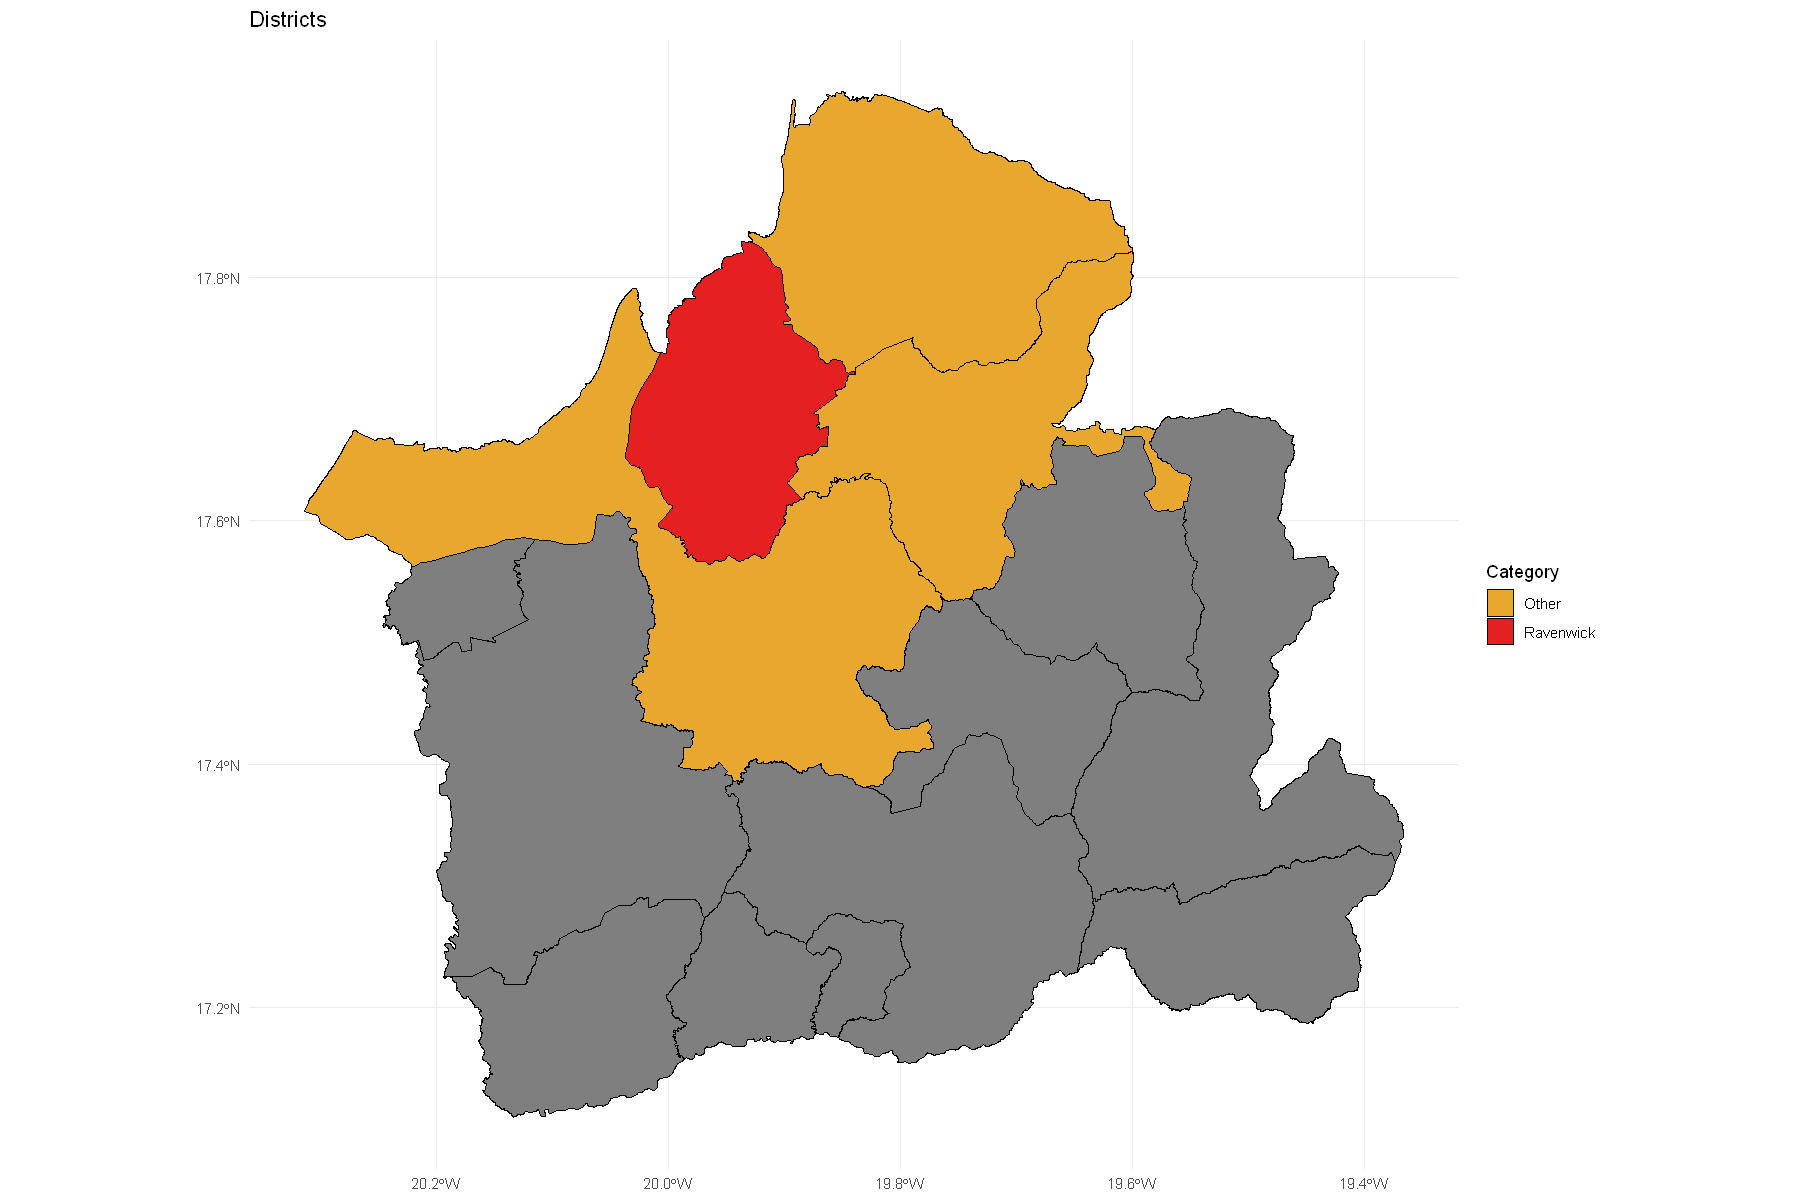

In [25]:
# Crear columna con categoría de color
shape_file <- shape_file %>%
  mutate(color_group = case_when(
    DPA_DESCAN == "Ravenwick" ~ "Ravenwick",
    DPA_DESCAN %in% c("Wolfstead", "Falconridge", "Mistbridge") ~ "Other",
    TRUE ~ "Other provinces"
  ))

# Graficar con ggplot
ggplot(shape_file) +
  geom_sf(aes(fill = color_group), color = "black", size = 0.2) +
  scale_fill_manual(values = c(
    "Ravenwick" = "#e52020",
    "Other" = "#e8a82f",
    "Resto" = "lightgray"
  )) +
  labs(title = "Districts", fill = "Category") +
  theme_minimal()
